In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from PIL import Image
%matplotlib inline

In [18]:
km_sign = []
other_sign = []
signals = []
switches = []
negatives = []
km_sign_im = glob.glob('image folder*.jpg')
signals_im = glob.glob('image folder*.jpg')
negatives_im = glob.glob('image folder*.jpg')
for image in km_sign_im:
    km_sign.append(image)    
for image in signals_im:
    signals.append(image)
for image in negatives_im:
    negatives.append(image)
print ( "Number of images containing km:", len(km_sign))
print ( "Number of images  containing signals:", len(signals))
print ( "Number of images  containing negatives:", len(negatives))

Number of images containing km: 5697
Number of images  containing signals: 1281
Number of images  containing negatives: 3780


In [19]:
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),  orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return features

In [20]:
orient = 12
pix_per_cell = 8
cell_per_block = 4
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size=(16, 16)
hist_bins=16

Analyzing pictures:  F:/Manhattan Project/final_data/ANNOTATED_KM\1591780465.1543427.jpg
Analyzing pictures:  F:/Manhattan Project/final_data/ANNOTATED_SIGNALS\1591780981.6416745.jpg
Analyzing pictures:  F:/Manhattan Project/final_data/ANNOTATED_NEG\1591805950.2415657.jpg


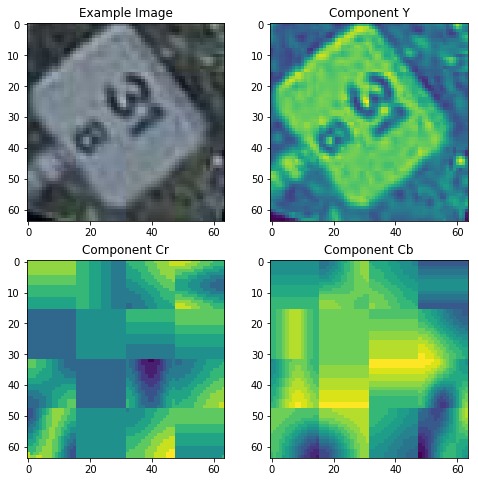

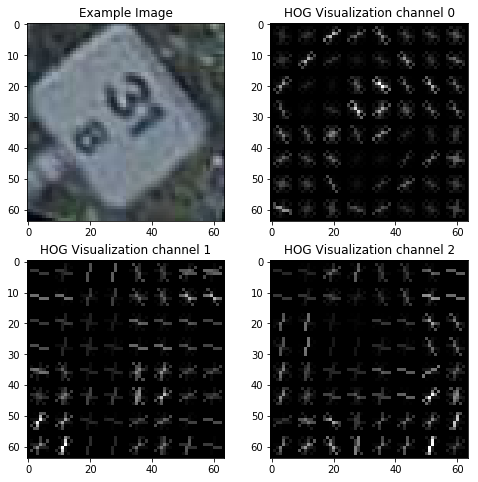

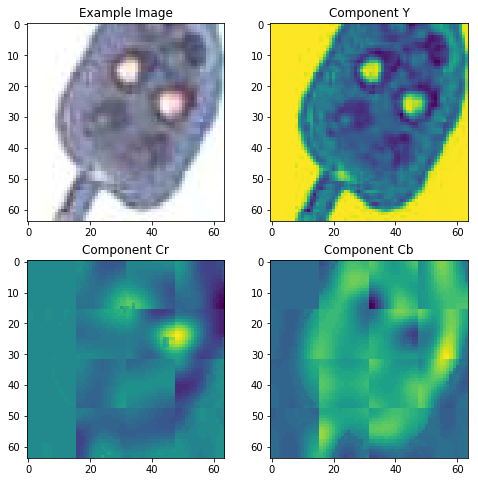

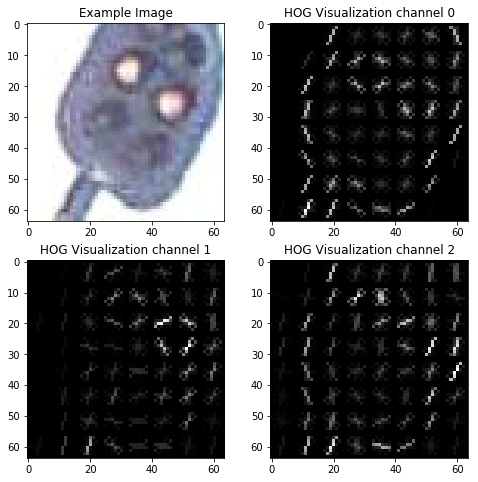

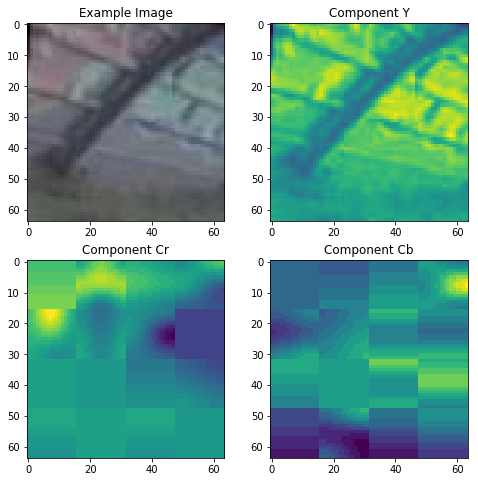

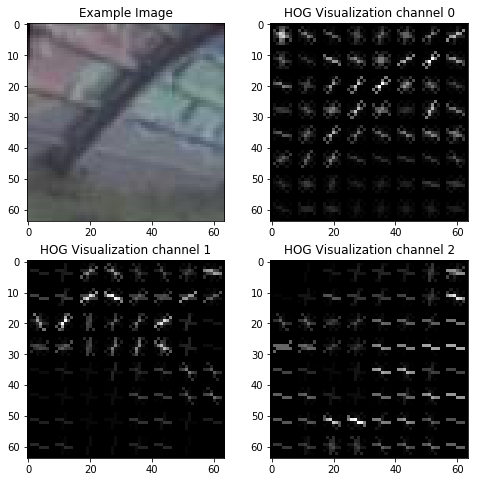

In [21]:
images = [km_sign[3],signals[10], negatives[1] ]
for img_p in images:
    print ("Analyzing pictures: ", img_p)
    image = mpimg.imread(img_p)
    image_YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    hog_features = []
    hog_images = []
    for channel in range(image_YCrCb.shape[2]):
        features, hog_image = get_hog_features(image_YCrCb[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
        hog_features.append(features)
        hog_images.append(hog_image)
    fig = plt.figure(figsize = (8,8))
    plt.subplot(221)
    plt.imshow(image)
    plt.title('Example Image')
    plt.subplot(222)
    plt.imshow(image_YCrCb[:,:,0])
    plt.title('Component Y')
    plt.subplot(223)
    plt.imshow(image_YCrCb[:,:,1])
    plt.title('Component Cr')
    plt.subplot(224)
    plt.imshow(image_YCrCb[:,:,2])
    plt.title('Component Cb')
    fig = plt.figure(figsize = (8,8))
    plt.subplot(221)
    plt.imshow(image)
    plt.title('Example Image')
    plt.subplot(222)
    plt.imshow(hog_images[0], cmap='gray')
    plt.title('HOG Visualization channel 0')
    plt.subplot(223)
    plt.imshow(hog_images[1], cmap='gray')
    plt.title('HOG Visualization channel 1')
    plt.subplot(224)
    plt.imshow(hog_images[2], cmap='gray')
    plt.title('HOG Visualization channel 2')

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import time
import pickle
[km_sign[1],signals[1], negatives[1] ]

print ('Extracting km features')
km_sign_features = extract_features(km_sign, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

print ('Extracting signals features')
signals_features = extract_features(signals, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

print ('Extracting negatives features')
negatives_features = extract_features(negatives, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
X = np.vstack((km_sign_features, negatives_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(km_sign_features)), np.zeros(len(negatives_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',spatial_size, 'spatial_size' , hist_bins, 'hist_bins')
print('HOG: Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Extracting km features


C:\Users\athit\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\athit\Anaconda3\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Extracting signals features
Extracting negatives features
Using: (16, 16) spatial_size 16 hist_bins
HOG: Using: 12 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 15216


## Radial Basis Function/ Gaussian Function

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import pandas as pd
svc = SVC(kernel = 'rbf', random_state = 0)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVM')
pred = svc.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
print ("Classification report for %s" % svc)
average_precision = average_precision_score(y_test, pred)
print (metrics.classification_report(y_test, pred))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

## Polynomial SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import pandas as pd
svc = SVC(kernel = 'poly',  C=1, gamma=0.001, random_state = 0)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVM')
pred = svc.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
print ("Classification report for %s" % svc)
average_precision = average_precision_score(y_test, pred)
print (metrics.classification_report(y_test, pred))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

## Linear SVC

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVM')
pred = svc.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
print ("Classification report for %s" % svc)
average_precision = average_precision_score(y_test, pred)
print (metrics.classification_report(y_test, pred))
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

## Linear SVC looking for the best C parameter

In [13]:
from sklearn.model_selection import GridSearchCV
svc1 = LinearSVC()
t=time.time()
parameters = {'C': [0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(svc1, parameters)
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.decision_function(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\Users\athit\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\athit\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\athit\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\athit\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\athit\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

757.6 Seconds to train SVC...
Test Accuracy of SVC =  0.989
My SVC predicts:  [-2.03472739 -0.69779921  5.38748111  3.46054585 -1.47147712 -0.84457172
  3.31320367  7.93173425 -2.00015098 -0.99956757]
For these 10 labels:  [0. 0. 1. 1. 0. 0. 1. 1. 0. 0.]
0.01296 Seconds to predict 10 labels with SVC
